# The data
This notebook aims at presenting the process of creating the end-to-end modelling pipeline with the use of [PyPlatypus](https://github.com/maju116/pyplatypus) package.

As starting point, the data is crucial, let's proceed with gathering it hence. We will be working with the nuclei-related images of which the [2018 Data Science Bowl dataset](https://www.kaggle.com/c/data-science-bowl-2018/data) is composed. These are PNG files organized in accordance with the following structure:

stage1_data

----|image_name

--------|images

------------|image.png

--------|masks

------------|mask1.png

------------|mask2.png

In the "images" folder you will find an image of shape (256, 256, 4) with the values varying from 0 to 1, while the masks are just (256, 256) matrices with the values coming from the discrete set: {0, 1}.

# The preparation
After downloading the data, unpack it and move to any preferred destination. For this example we will be interested only in stage1_train and stage1_test subdirectories, thus other files could be put aside. Let's take a look at the exemplary image.

In [1]:
from pathlib import Path
import os
cwd = Path.cwd()
while cwd.stem != "pyplatypus":
    cwd = cwd.parent
os.chdir(cwd)

In [2]:
# 20% for validation
data_path = Path("examples/data/data_science_bowl/")
models_path = Path("examples/models/")

example = "0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9"
train_image = os.listdir(data_path/Path(f"stage1_train/{example}/images"), )
train_masks = os.listdir(data_path/Path(f"stage1_train/{example}/masks"))

In [3]:
from matplotlib import pyplot as plt
# Load the image along with on of the masks associated
example_image = plt.imread(data_path/Path(f"stage1_train/{example}/images/{train_image[0]}"))
example_mask1 = plt.imread(data_path/Path(f"stage1_train/{example}/masks/{train_masks[0]}"))
example_mask2 = plt.imread(data_path/Path(f"stage1_train/{example}/masks/{train_masks[2]}"))

Text(0.5, 1.0, 'Original image with the masks in yellow.')

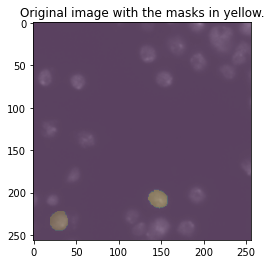

In [4]:
plt.figure()
plt.imshow(example_image, alpha=0.6)
plt.imshow(example_mask1, alpha=0.2)
plt.imshow(example_mask2, alpha=0.2)
plt.title("Original image with the masks in yellow.")

What you see as the yellow area is the "Segmentation mask" which is simply telling us which pixel belongs to which class. Assesing this membership is the goal that we are striving to achieve.

# Splitting the data
For the modeling, beside train and test sets, we will need a validation set for it is common good practice to have one.
Feel free to use the following script but beware, it will move a sample set of images from yout stage1_train folder to the stage1_validation.

In [5]:
from glob import glob
from random import sample
from shutil import move

def create_validation_set(data_path, p=0.2):
    train_images = glob(str(data_path/Path("stage1_train/*")))
    # Validation set size (as percentage)
    p = 0.2
    validation_images = sample(train_images, round(p*len(train_images)))
    Path.mkdir(data_path/Path("stage1_validation"))
    for img_path in validation_images:
        trimmed_path = Path(img_path).stem
        move(img_path, str(data_path/Path(f"stage1_validation/{trimmed_path}")))

Let's now inspect the input message that we are to send to PlatypusSolver in order to run it.

In [6]:
import yaml
import json
with open(r"examples/data_science_bowl_config.yaml") as stream:
    config = yaml.safe_load(stream)
    print(json.dumps(config, indent=4, sort_keys=True))

{
    "augmentation": {
        "Blur": {
            "always_apply": false,
            "blur_limit": 7,
            "p": 0.5
        },
        "Flip": {
            "always_apply": false,
            "p": 0.5
        },
        "RandomRotate90": {
            "always_apply": false,
            "p": 0.5
        },
        "ToFloat": {
            "always_apply": true,
            "max_value": 255,
            "p": 1.0
        }
    },
    "object_detection": null,
    "semantic_segmentation": {
        "data": {
            "colormap": [
                [
                    0,
                    0,
                    0
                ],
                [
                    255,
                    255,
                    255
                ]
            ],
            "column_sep": ";",
            "loss": "focal loss",
            "metrics": [
                "tversky coefficient",
                "iou coefficient"
            ],
            "mode": "nested_dirs",
           

What might have struck you is that the config is organized so that it might potentially tell the Solver to train multiple models while using a complex augmentation pipeline and loss functions coming from the rather large set of ones available within the PyPlatypus framework.

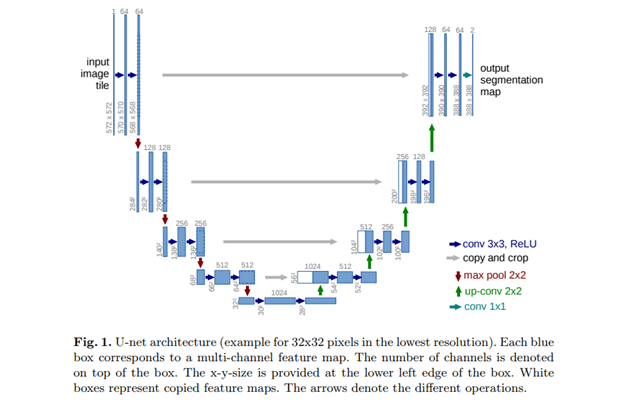

# The model

The models present in the PyPlatypus segmentation submodule are U-Net based.

U-Net was originally developed for biomedical data segmentation. As you can see in the picture above architecture is very similar to autoencoder and it looks like the letter U, hence the name. Model is composed of 2 parts, and each part has some number of convolutional blocks (3 in the image above). Number of blocks will be hyperparameter in our model.

To build a U-Net model in platypus use u_net function. You have to specify:

* Number of convolutional blocks,
* Input image height and width - it need not to be in the form 2^N, as we added the generalizng layer.
* Indicator determining if the input image will be loaded as grayscale or RGB.
* Number of classes - in our case we have only 2 (background and nuclei).
* Additional arguments for CNN such as: number of filters, dropout rate etc.

Hereafter the models' building process is rather straightforward.

In [7]:
from platypus.solvers.platypus_cv_solver import PlatypusSolver


ps = PlatypusSolver(
    config_yaml_path=Path("examples/data_science_bowl_config.yaml")
)
ps.train()

536 images detected!
Set 'steps_per_epoch' to: 17
134 images detected!
Set 'steps_per_epoch' to: 5
134 images detected!
Set 'steps_per_epoch' to: 5


2022-09-27 12:29:23.944424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 12:29:23.953642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 12:29:23.953966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 12:29:23.959581: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/100


2022-09-27 12:29:32.545612: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


17/17 [==============================] - 47s 2s/step - loss: 0.1463 - tversky_coefficient: 0.5225 - categorical_crossentropy: 0.6720 - iou_coefficient: 0.3539 - val_loss: 0.1461 - val_tversky_coefficient: 0.5011 - val_categorical_crossentropy: 0.7013 - val_iou_coefficient: 0.3344
Epoch 2/100
17/17 [==============================] - 37s 2s/step - loss: 0.1044 - tversky_coefficient: 0.5623 - categorical_crossentropy: 0.5887 - iou_coefficient: 0.3913 - val_loss: 0.1518 - val_tversky_coefficient: 0.4892 - val_categorical_crossentropy: 0.7173 - val_iou_coefficient: 0.3238
Epoch 3/100
17/17 [==============================] - 36s 2s/step - loss: 0.0809 - tversky_coefficient: 0.6115 - categorical_crossentropy: 0.5100 - iou_coefficient: 0.4405 - val_loss: 0.2693 - val_tversky_coefficient: 0.4141 - val_categorical_crossentropy: 0.8949 - val_iou_coefficient: 0.2613
Epoch 4/100
17/17 [==============================] - 39s 2s/step - loss: 0.0673 - tversky_coefficient: 0.6430 - categorical_crossentr

Epoch 29/100
17/17 [==============================] - 38s 2s/step - loss: 0.0206 - tversky_coefficient: 0.8287 - categorical_crossentropy: 0.2045 - iou_coefficient: 0.7075 - val_loss: 0.0866 - val_tversky_coefficient: 0.7898 - val_categorical_crossentropy: 0.3124 - val_iou_coefficient: 0.6536
Epoch 30/100
17/17 [==============================] - 44s 3s/step - loss: 0.0201 - tversky_coefficient: 0.8294 - categorical_crossentropy: 0.2031 - iou_coefficient: 0.7086 - val_loss: 0.1246 - val_tversky_coefficient: 0.8190 - val_categorical_crossentropy: 0.3148 - val_iou_coefficient: 0.6949
Epoch 31/100
17/17 [==============================] - 41s 2s/step - loss: 0.0197 - tversky_coefficient: 0.8364 - categorical_crossentropy: 0.1949 - iou_coefficient: 0.7189 - val_loss: 0.0956 - val_tversky_coefficient: 0.8171 - val_categorical_crossentropy: 0.2911 - val_iou_coefficient: 0.6919
Epoch 32/100
17/17 [==============================] - 41s 2s/step - loss: 0.0197 - tversky_coefficient: 0.8365 - categ

Epoch 57/100
17/17 [==============================] - 43s 3s/step - loss: 0.0162 - tversky_coefficient: 0.8673 - categorical_crossentropy: 0.1580 - iou_coefficient: 0.7657 - val_loss: 0.0154 - val_tversky_coefficient: 0.8924 - val_categorical_crossentropy: 0.1334 - val_iou_coefficient: 0.8062
Epoch 58/100
17/17 [==============================] - 45s 3s/step - loss: 0.0164 - tversky_coefficient: 0.8691 - categorical_crossentropy: 0.1561 - iou_coefficient: 0.7686 - val_loss: 0.0151 - val_tversky_coefficient: 0.8910 - val_categorical_crossentropy: 0.1348 - val_iou_coefficient: 0.8038
Epoch 59/100
17/17 [==============================] - 42s 2s/step - loss: 0.0159 - tversky_coefficient: 0.8693 - categorical_crossentropy: 0.1556 - iou_coefficient: 0.7688 - val_loss: 0.0150 - val_tversky_coefficient: 0.8956 - val_categorical_crossentropy: 0.1297 - val_iou_coefficient: 0.8113
Epoch 60/100
17/17 [==============================] - 42s 2s/step - loss: 0.0159 - tversky_coefficient: 0.8723 - categ

Epoch 85/100
17/17 [==============================] - 40s 2s/step - loss: 0.0149 - tversky_coefficient: 0.8809 - categorical_crossentropy: 0.1421 - iou_coefficient: 0.7872 - val_loss: 0.0147 - val_tversky_coefficient: 0.9043 - val_categorical_crossentropy: 0.1194 - val_iou_coefficient: 0.8257
Epoch 86/100
17/17 [==============================] - 37s 2s/step - loss: 0.0154 - tversky_coefficient: 0.8826 - categorical_crossentropy: 0.1407 - iou_coefficient: 0.7899 - val_loss: 0.0145 - val_tversky_coefficient: 0.9011 - val_categorical_crossentropy: 0.1247 - val_iou_coefficient: 0.8206
Epoch 87/100
17/17 [==============================] - 40s 2s/step - loss: 0.0151 - tversky_coefficient: 0.8820 - categorical_crossentropy: 0.1411 - iou_coefficient: 0.7889 - val_loss: 0.0145 - val_tversky_coefficient: 0.9078 - val_categorical_crossentropy: 0.1165 - val_iou_coefficient: 0.8317
Epoch 88/100
17/17 [==============================] - 40s 2s/step - loss: 0.0149 - tversky_coefficient: 0.8837 - categ

Epoch 40/100
67/67 [==============================] - 44s 662ms/step - loss: 0.0199 - categorical_crossentropy: 0.1687 - tversky_coefficient: 0.8613 - iou_coefficient: 0.7565 - val_loss: 0.1118 - val_categorical_crossentropy: 0.5171 - val_tversky_coefficient: 0.6285 - val_iou_coefficient: 0.4600
Epoch 41/100
67/67 [==============================] - 45s 670ms/step - loss: 0.0209 - categorical_crossentropy: 0.1708 - tversky_coefficient: 0.8603 - iou_coefficient: 0.7551 - val_loss: 0.0568 - val_categorical_crossentropy: 0.2460 - val_tversky_coefficient: 0.8208 - val_iou_coefficient: 0.6973
Epoch 42/100
67/67 [==============================] - 46s 679ms/step - loss: 0.0200 - categorical_crossentropy: 0.1665 - tversky_coefficient: 0.8633 - iou_coefficient: 0.7598 - val_loss: 0.0475 - val_categorical_crossentropy: 0.2765 - val_tversky_coefficient: 0.7871 - val_iou_coefficient: 0.6503
Epoch 43/100
67/67 [==============================] - 45s 665ms/step - loss: 0.0195 - categorical_crossentrop

Epoch 68/100
67/67 [==============================] - 44s 654ms/step - loss: 0.0175 - categorical_crossentropy: 0.1486 - tversky_coefficient: 0.8776 - iou_coefficient: 0.7821 - val_loss: 0.0620 - val_categorical_crossentropy: 0.3737 - val_tversky_coefficient: 0.7139 - val_iou_coefficient: 0.5567
Epoch 69/100
67/67 [==============================] - 45s 671ms/step - loss: 0.0176 - categorical_crossentropy: 0.1491 - tversky_coefficient: 0.8772 - iou_coefficient: 0.7815 - val_loss: 0.0889 - val_categorical_crossentropy: 0.3982 - val_tversky_coefficient: 0.7125 - val_iou_coefficient: 0.5564
Epoch 70/100
67/67 [==============================] - 46s 684ms/step - loss: 0.0172 - categorical_crossentropy: 0.1470 - tversky_coefficient: 0.8788 - iou_coefficient: 0.7841 - val_loss: 0.0216 - val_categorical_crossentropy: 0.1763 - val_tversky_coefficient: 0.8562 - val_iou_coefficient: 0.7501
Epoch 71/100
67/67 [==============================] - 45s 666ms/step - loss: 0.0178 - categorical_crossentrop

Epoch 96/100
67/67 [==============================] - 46s 678ms/step - loss: 0.0158 - categorical_crossentropy: 0.1355 - tversky_coefficient: 0.8881 - iou_coefficient: 0.7990 - val_loss: 0.0198 - val_categorical_crossentropy: 0.1595 - val_tversky_coefficient: 0.8702 - val_iou_coefficient: 0.7720
Epoch 97/100
67/67 [==============================] - 48s 716ms/step - loss: 0.0163 - categorical_crossentropy: 0.1383 - tversky_coefficient: 0.8860 - iou_coefficient: 0.7957 - val_loss: 0.0544 - val_categorical_crossentropy: 0.2859 - val_tversky_coefficient: 0.7852 - val_iou_coefficient: 0.6490
Epoch 98/100
67/67 [==============================] - 48s 706ms/step - loss: 0.0162 - categorical_crossentropy: 0.1371 - tversky_coefficient: 0.8870 - iou_coefficient: 0.7973 - val_loss: 0.0196 - val_categorical_crossentropy: 0.1496 - val_tversky_coefficient: 0.8788 - val_iou_coefficient: 0.7856
Epoch 99/100
67/67 [==============================] - 48s 710ms/step - loss: 0.0169 - categorical_crossentrop

# Predictions

Only after do we train the models, we can easily produce predicted masks based on the validation set or whatever data that we would like to use, just make sure it is organized as in the train/validation/test sets.

In [211]:
from glob import glob
from random import sample
from PIL import Image
import numpy as np

def sample_and_plot_predictions(data_path: Path, model_name: str, n=3):
    validation_images = glob(str(data_path/Path("stage1_validation/*")))
    # Sample size
    n_max = len(validation_images)
    n=n_max if n > n_max else n
    validation_images = sample(validation_images, n)
    for img_path in validation_images:
        img_name = img_path.split("/")[-1:][0]
        img = glob(f"{img_path}/images/*.png")[0]
        predictions = glob(f"{img_path}/predicted_masks/{model_name}_predicted_mask.png")[0]
        masks = glob(f"{img_path}/masks/*.png")
        # Load images
        img_loaded = Image.open(img) 
        original_size = img_loaded.size
        np_original_size = tuple(reversed(original_size))
        # Load masks and squeeze them into one frame
        masks_frame = np.zeros(np_original_size)
        masks_frame = prepare_masks(masks, np_original_size, masks_frame)
        # Load predictions
        predictions_loaded = Image.open(predictions)
        original_size_scaled = (np.array(original_size)/2).astype(int)
        predictions_scaled = predictions_loaded.resize(original_size_scaled)
        # Plot image alongside true and predicted masks
        f, axarr = plt.subplots(1,3)
        plt.title(f"Image and predictions: {img_name}")
        axarr[0].imshow(img_loaded)
        axarr[1].imshow(masks_frame)
        axarr[2].imshow(predictions_scaled)

In [179]:
validation_images = glob(str(data_path/Path("stage1_validation/*")))
# Sample size
n_max = len(validation_images)
n=n_max if n > n_max else n
validation_images = sample(validation_images, n)
for img_path in validation_images[:5]:
    img_name = img_path.split("/")[-1:][0]
    img = glob(f"{img_path}/images/*.png")[0]
    predictions = glob(f"{img_path}/predicted_masks/{model_name}_predicted_mask.png")[0]
    masks = glob(f"{img_path}/masks/*.png")
    # Load images
    img_loaded = Image.open(img) 
    original_size = img_loaded.size
    # Load masks and squeeze them into one frame
    masks_frame = np.zeros(original_size)
    

In [180]:
original_size

(696, 520)

In [210]:
def prepare_masks(masks, np_original_size, masks_frame):
    for mask in masks:
        loaded_mask_ = plt.imread(mask)
        if loaded_mask_.shape != np_original_size:
            rotated_loaded_mask_ = np.rot90(loaded_mask_)
            masks_frame += rotated_loaded_mask_
        else:
            masks_frame += loaded_mask_
        return masks_frame
        

In [9]:
# Clean the results of former runs
from glob import glob
from shutil import rmtree
masks = glob(str(data_path/"stage1_validation/**/predicted_*"))
for mask in masks:
    rmtree(mask)


In [114]:
# When the custom_data_path is set to None, the validation data will be used.
# If that is not the intention of yours, feel free to point the engine to any other direction.
ps.produce_and_save_predicted_masks_for_model(model_name="u_net_plus_plus", custom_data_path=None)

1/1 [==============================] - 0s 415ms/step


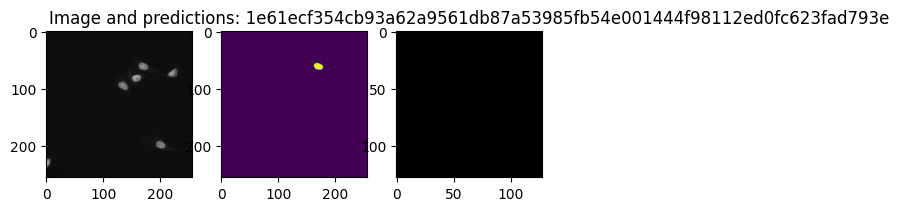

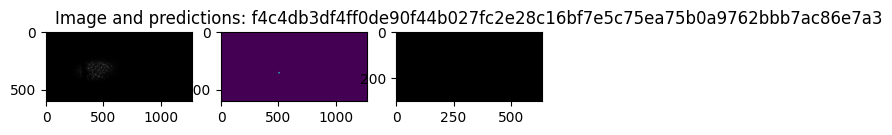

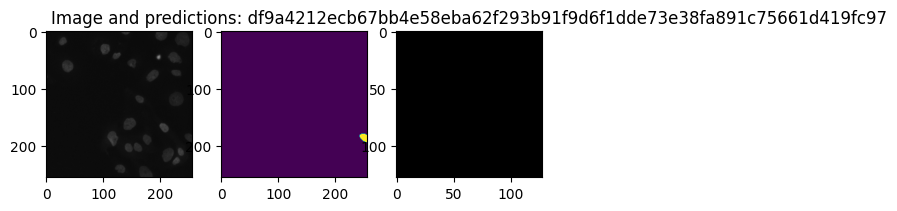

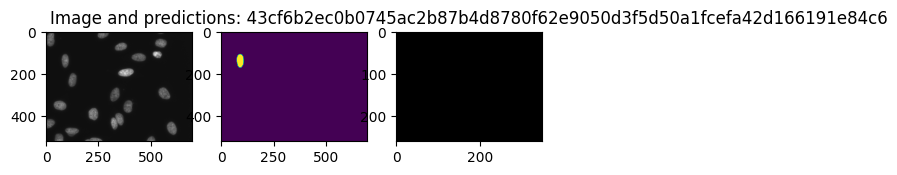

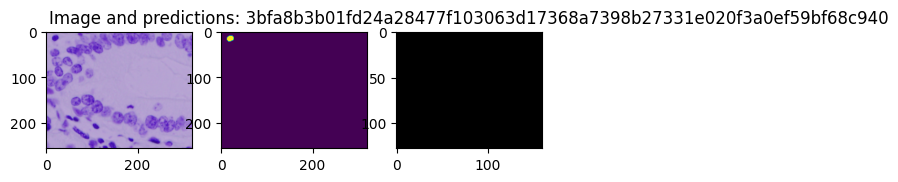

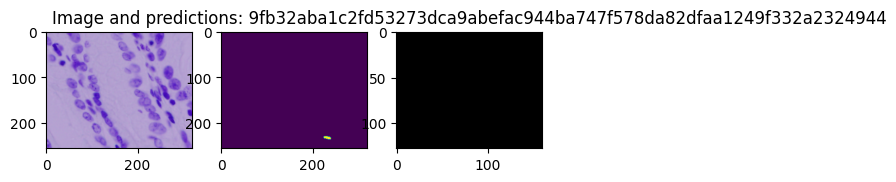

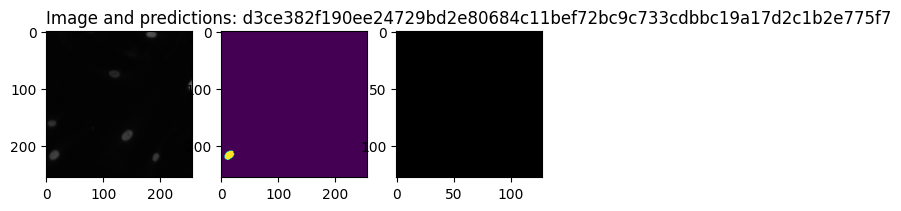

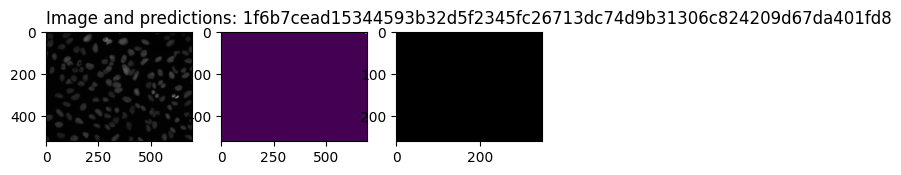

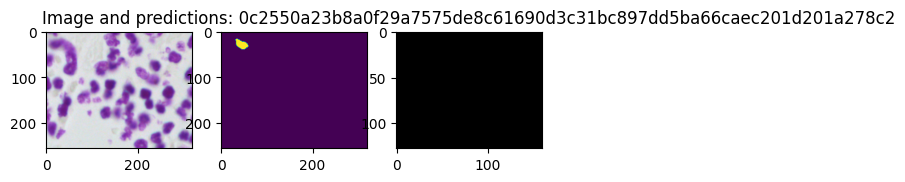

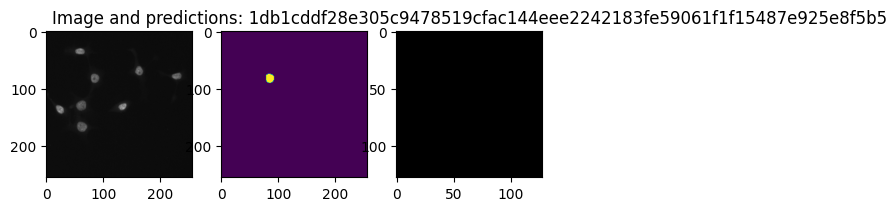

In [213]:
sample_and_plot_predictions(data_path, model_name="u_net_plus_plus", n=10)

In [12]:
ps.produce_and_save_predicted_masks_for_model(model_name="res_u_net", custom_data_path=None)

1/1 [==============================] - 1s 515ms/step


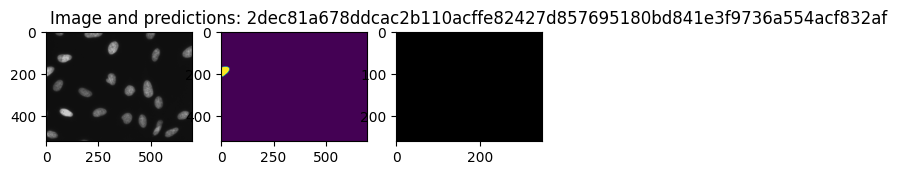

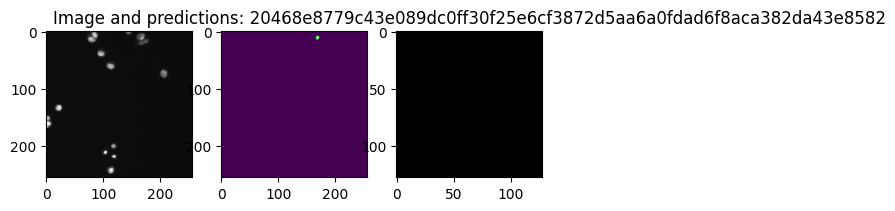

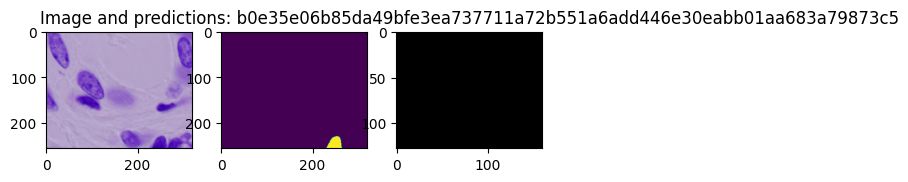

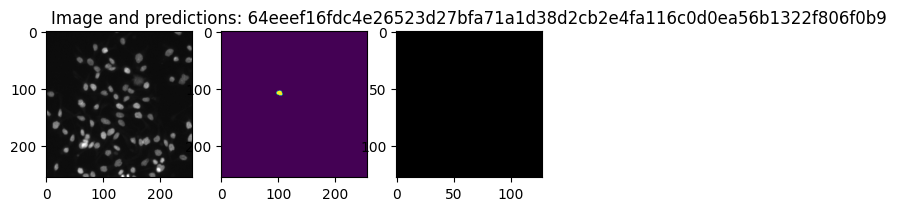

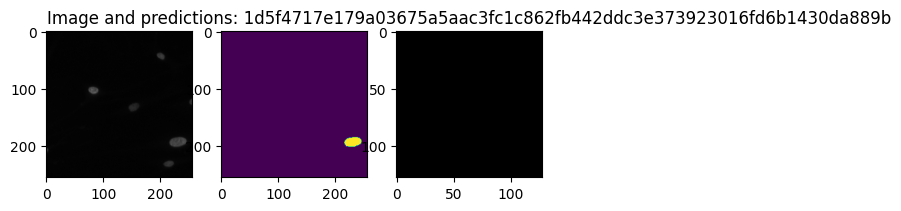

In [212]:
sample_and_plot_predictions(data_path, model_name="u_net_plus_plus", n=5)